In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from scipy.stats import zscore

"""
https://www.kaggle.com/competitions/titanic/data

Creating a model for predicting survival on the titanic

Created by Cin A. (aka Lance Aquino)
"""


'\nhttps://www.kaggle.com/competitions/titanic/data\n\nCreating a model for predicting survival on the titanic\n\nCreated by Cin A. (aka Lance Aquino)\n'

# Preprocessing and exploratory analysis

In [2]:
df_gs = pd.read_csv("gender_submission.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")

In [3]:
df_test = pd.read_csv("test.csv")
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We should exclude the cabin category, due to the large number of NaNs.
Age should probably also be imputed by means, due to the high number of NaNs

We should also exclude names, as they won't be used in the model.

In [6]:
# converting label encoded data to their respective labels
survival_key = {0:"No", 1: "Yes"}
class_key = {1:"1st", 2 : "2", 3:"3rd"}


In [7]:
def process_data(df):
    """
    Removes columns that are redundant (Ticket) ,have many 
    NaNs (Cabin), or otherwise unimportant (Name) for applying a
    machine learning model from X, and separates the thing
    we're predicting (Survived) into y.
    
    returns:
    X: processed data where Ticket, Name, Cabin, and Survived are removed, PassengerId becomes the indeces
    y: processed data where survival status is recorded (0 for lived, 1 for not)
    """
        
    # sets PassengerId as the index for all data
    X = df.set_index("PassengerId")
    y = X["Survived"] # also set y to X["Survived"] before removing it
    
    # Removes unimportant columns and y data from the X df
    X = X.drop(["Survived","Ticket","Name","Cabin"],axis = 1)
    le = preprocessing.LabelEncoder()
    
    # encodes categorical data as ints
    X["Sex"] = le.fit_transform(X["Sex"])
    X["Embarked"] = le.fit_transform(X["Embarked"])
    
    # imputes NaN data in age by adding the mean of the column
    imp_means = SimpleImputer(missing_values=np.nan,strategy ="mean") #fills in NaNs
    age_arr = np.array(X["Age"]).reshape(-1,1) # need to reshape to get it to work in the imputer
    age_arr_imp = imp_means.fit_transform(age_arr) # fills in nans within X_processed 
    
    # zscoring continuous variables
    X["Age"] = zscore(age_arr_imp) # overwrites ages with zscored ages
    X["Fare"] = zscore(X["Fare"])
    
    return X,y
X,y = process_data(df_train)
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,1,-0.592481,1,0,-0.502445,2
2,1,0,0.638789,1,0,0.786845,0
3,3,0,-0.284663,0,0,-0.488854,2
4,1,0,0.407926,1,0,0.420730,2
5,3,1,0.407926,0,0,-0.486337,2
...,...,...,...,...,...,...,...
887,2,1,-0.207709,0,0,-0.386671,2
888,1,0,-0.823344,0,0,-0.044381,2
889,3,0,0.000000,1,2,-0.176263,2


In [8]:
y

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

# Cross-validation for the model we want to use

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.model_selection import  cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

## Logistic Regression?

In [10]:
# L2 vs L1
kf = KFold(n_splits=5,shuffle = True)
X,y = process_data(df_train)

num_iterations = 100
# Cross validating L1 and recording the average score
l1_avg_scores = []

LR_L1 = LogisticRegression(penalty = "l1",solver = "liblinear",max_iter = 1000)
LR_L1.fit(X,y)
for i in range (num_iterations):
    l1_acc = np.mean(cross_val_score(LR_L1, X,y,cv = kf))
    l1_avg_scores.append(l1_acc)

# Cross validating L2 and recording the average score
l2_avg_scores = []
LR_L2 = LogisticRegression(penalty = "l2",solver = "liblinear",max_iter = 1000)
LR_L2.fit(X,y)
for i in range (num_iterations):
    l2_acc = np.mean(cross_val_score(LR_L2, X,y, cv=kf))
    l2_avg_scores.append(l2_acc)

[Text(0.5, 1.0, 'Comparison between L1 and L2 Logistic Regression using liblinear solver'),
 Text(0, 0.5, 'Model Accuracy')]

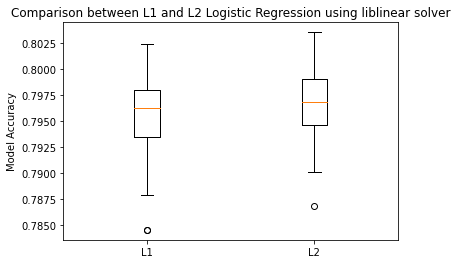

In [12]:
fig,ax = plt.subplots(1)
l1_l2 = pd.DataFrame({"L1":l1_avg_scores,
                      "L2":l2_avg_scores})
labels = ["L1","L2"]
ax.boxplot(l1_l2,labels = labels)
ax.set(
    title = "Comparison between L1 and L2 Logistic Regression using liblinear solver",
    ylabel = "Model Accuracy"
)


It seems that on average, L2 performs better than L1 when cross validated 100 times over 5 folds, where both types of regression utilize the liblinear solver algorithm

In [13]:
# Elastic net mixing parameters (l1_ratio)
L1_ratios = np.linspace(0,1,11)
#enet_avg_scores = []

best_enet_score = -np.inf
best_l1_ratio = -np.inf
scores = []
for a in L1_ratios:
    kf = KFold(n_splits=5,shuffle = True, random_state = 42)
    lr_enet = LogisticRegression(solver = "saga",penalty = "elasticnet",l1_ratio =a ,max_iter = 7000)
    lr_enet.fit(X,y)
    lr_enet_acc = np.mean(cross_val_score(lr_enet, X,y, cv=kf))
    scores.append(lr_enet_acc)
    if lr_enet_acc>best_enet_score:
        best_enet_score = lr_enet_acc
        best_l1_ratio = a
template = "Best Elastic Net L1 mixing Parameter: {0} (score = {1})"
print(template.format(best_l1_ratio,lr_enet_acc))

Best Elastic Net L1 mixing Parameter: 0.1 (score = 0.7990898248697509)


Elastic net seems to perform about as good as both L1 and L2 when we tried to cross validate for its best parameter, so I'm deciding to stick L2

## Random Forest?

In [14]:
N=100 #largest max depth/n_estimator

X,y = process_data(df_train)

kf = KFold(n_splits=5,shuffle = True,random_state = 42)

best_n_estimators = 0
best_ne_score=-np.inf
ne_scores=np.zeros(N)

best_depth = 0
best_depth_score = -np.inf
depth_scores=np.zeros(N)

#Cross validating for number of estimators/trees
for ne in range(1,N+1): #iterates through values 1 - 40 to use as the number of estimators for of the model
    
    RF = RandomForestClassifier(n_estimators=ne)
    
    #adds the average score in 10 folds to the list 
    # ne-1 since the range starts at 1
    
    ne_scores[ne-1]=cross_val_score(RF,X,y,cv=kf).mean()
    
    # if the current score is better, replaces the best recorded best_ne_score with current one
    if ne_scores[ne-1]>best_ne_score:
        best_n_estimators=ne #sets the best estimator
        best_ne_score=ne_scores[ne-1] # record its score
        
#Cross validating for the max depth of the trees

for d in range(1,N+1): #iterates through values 1 - 40 to use as the the max depth of the model
    
    RF = RandomForestClassifier(max_depth=d,n_estimators=best_n_estimators)
    
    #adds the average score in 10 folds to the list 
    depth_scores[d-1]=cross_val_score(RF,X,y,cv=kf).mean()
    if depth_scores[d-1]>best_depth_score: # if the current score is better, replaces the best recorded depth with current
        best_depth=d
        best_depth_score=depth_scores[d-1]

template_ne = "Best n_estimators: {0} (score = {1})"
template_d = "Best max_depth: {0} (score = {1})"

print(template_ne.format(best_n_estimators,best_ne_score))
print(template_d.format(best_depth,best_depth_score))

Best n_estimators: 95 (score = 0.8249074132195092)
Best max_depth: 8 (score = 0.8339150084740444)


In [15]:
kf = KFold(n_splits=5,shuffle = True)
num_iterations = 100

# measuring the performance of the random forest on 5-folds 100 cross valdationss
rf_avg_scores = []
RF = RandomForestClassifier(max_depth=best_depth,
                            n_estimators=best_n_estimators)
RF.fit(X,y)
for i in range (num_iterations):
    rf_acc = np.mean(cross_val_score(RF, X,y,cv = kf))
    rf_avg_scores.append(rf_acc)

RF (max_depth = 95, n_estimators = 8)


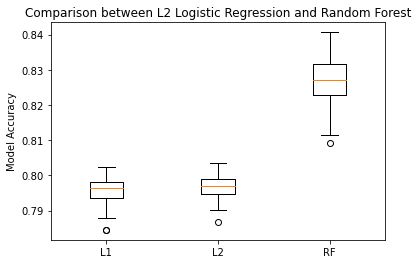

In [16]:
fig,ax = plt.subplots(1)
l1_rf_scores = pd.DataFrame({"L1":l1_avg_scores,
                             "L2":l2_avg_scores,
                             "RF":rf_avg_scores})

rf_template = "RF (max_depth = {0}, n_estimators = {1})"
labels = ["L1","L2","RF"]
ax.boxplot(l1_rf_scores,labels = labels)
ax.set(
    title = "Comparison between L2 Logistic Regression and Random Forest",
    ylabel = "Model Accuracy"
)

print(rf_template.format(best_n_estimators,best_depth))

Random forests appear to perform slightly better than L2 and L1, but have a larger range of accuracies

# Final Evaluation

In [17]:
# First, we need to combine the data with the original train data, so that the standardization is the same
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [18]:
def preprocessing_for_test(df_train,df_test):
    """
    Combines training with test data,
    in order to normalize the test data with
    the training set
    
    returns:
    df_test_norm: normalized test set, with PassengerIds set as the index
    """
    
    test_IDs = df_test["PassengerId"] # recording the passenger IDs
    
    # combines all data into one set so that the test data is included in normalization
    df_test_norm = pd.concat([df_train, df_test], axis = 0).set_index("PassengerId") 
    
    # Removes unimportant columns and y data from the df_test_norm 
    df_test_norm = df_test_norm.drop(["Survived","Ticket","Name","Cabin"],axis = 1)
    le = preprocessing.LabelEncoder()
    
    # encodes categorical data as ints
    le = preprocessing.LabelEncoder()
    df_test_norm["Sex"] = le.fit_transform(df_test_norm["Sex"])
    df_test_norm["Embarked"] = le.fit_transform(df_test_norm["Embarked"])
    
    # imputes NaN data in age by adding the mean of the column
    imp_means = SimpleImputer(missing_values=np.nan,strategy ="mean") #fills in NaNs
    age_arr = np.array(df_test_norm["Age"]).reshape(-1,1) # need to reshape to get it to work in the imputer
    age_arr_imp = imp_means.fit_transform(age_arr) # fills in nans within X_processed 
    
     # imputes NaN data in Fare by adding the mean of the column
    fare_arr = np.array(df_test_norm["Fare"]).reshape(-1,1) # need to reshape to get it to work in the imputer
    fare_arr_imp = imp_means.fit_transform(fare_arr) # fills in nans within X_processed 
    
    # zscoring continuous variables
    df_test_norm["Age"] = zscore(age_arr_imp) # overwrites ages with zscored ages
    df_test_norm["Fare"] =zscore(fare_arr_imp)
    return df_test_norm.loc[test_IDs]
df_test_norm = preprocessing_for_test(df_train,df_test)
df_test_norm

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,1,0.358655,0,0,-0.492396,1
893,3,0,1.329283,1,0,-0.508429,2
894,2,1,2.494035,0,0,-0.456465,1
895,3,1,-0.223721,0,0,-0.476284,2
896,3,0,-0.611972,1,1,-0.406194,2
...,...,...,...,...,...,...,...
1305,3,1,0.000000,0,0,-0.488127,2
1306,1,0,0.708081,0,0,1.461829,0
1307,3,1,0.669256,0,0,-0.503595,2


In [24]:
X_train,y_train = process_data(df_train)

RF = RandomForestClassifier(max_depth=best_depth,
                            n_estimators=best_n_estimators)
RF.fit(X_train,y_train)

survive_preds = RF.predict(df_test_norm)
survive_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Exporting the csv 

In [26]:
df_test_norm["Survived"] = survive_preds

In [29]:
export_df = df_test_norm["Survived"] 
export_df

PassengerId
892     0
893     0
894     0
895     0
896     1
       ..
1305    0
1306    1
1307    0
1308    0
1309    1
Name: Survived, Length: 418, dtype: int64

In [31]:
export_df.to_csv("cval_rf_submission.csv")